In [191]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display, HTML

from PIL import Image, ImageOps
import numpy as np
import matplotlib.pyplot as plt
import PIL, copy, ipyplot
import pandas as pd

from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=True)

### Image processing subroutines

In [297]:
def getImages(stat, rng, nums, xsize = 120, ysize = 60):
    
    images = [Image.open(f"./dataset1/Hindi/{str(j).zfill(3)}/H-S-{str(j)}-{stat}-{str(i).zfill(2)}.tif") for j in rng for i in nums]
    lbls = [j for j in rng for i in nums]
            
    return lbls, [crop(np.array(im), im.size).resize((xsize, ysize)) for im in images]

def vecToImage(vec, xsize = 120, ysize = 60):
    return Image.fromarray(np.uint8(np.reshape(vec, (ysize, xsize)) * 255))

def imageToVec(img):
    return np.array(img).flatten() / 255

def border(im):
    return ImageOps.expand(im, border = 1, fill='black')

def convertToBin(img):
    return vecToImage((imageToVec(img) > 0.9).astype(int), *img.size)

def crop(im, size):
    indices = [0, 0, 0, 0]
    
    for i in range(size[1]):
        if(np.count_nonzero(im[i, :] == 0) != 0):
            indices[0] = i
            break
    
    for i in range(size[0]):
        if(np.count_nonzero(im[:, i] == 0) != 0):
            indices[1] = i
            break
    
    for i in reversed(range(size[0])):
        if(np.count_nonzero(im[:, i] == 0) != 0):
            indices[2] = i
            break
            
    for i in reversed(range(size[1])):
        if(np.count_nonzero(im[i, :] == 0) != 0):
            indices[3] = i
            break
    
    return Image.fromarray(im[indices[0]: indices[3], indices[1]:indices[2]])

### Signature and labels class setup 

In [298]:
#find the index of the closest centroid
def closestCentroid(vec, centroids, dist):
    distances = np.array([dist(vec, centroid) for centroid in centroids])
    return np.argmin(distances)

#assigns label to centroid based on the points in its cluster
def getCentroidLabel(clusters, num):
    lst = [elt.label for elt in clusters[num]]
    lbl = max(set(lst), key=lst.count)
    return lbl if(lst.count(lbl) >= len(clusters[num])/2) else "Undefined"

class signature:
    def __init__(self, img, label):
        self.point = img
        self.label = label

### Final display subroutines

In [299]:
def showCentroids(centroids):
    return [border(vecToImage(centroid.point)) for centroid in centroids]

def showClusters(centroids, clusters, num):
    im = [border(vecToImage(elt.point)) for elt in clusters[num]]
    im.insert(0, border(vecToImage(centroids[num].point)))
    return im

def displayClusters(num):
    lbls = [elt.label for elt in clusters[num]]
    lbls.insert(0, "Centroid: " + centroids[num].label)
    return ipyplot.plot_images(showClusters(centroids, clusters, num), img_width = 120, labels = lbls)

### Distance metrics

In [300]:
def euclidean(vec1, vec2):
    return np.sqrt(np.sum(np.square(np.subtract(vec2, vec1))))

def eisencosine(vec1, vec2):
    return 1 - np.dot(vec1, vec2)/(np.sum(np.square(vec1)) * np.sum(np.square(vec2)))**0.5

def manhattan(vec1, vec2):
    return np.sum(np.abs(np.subtract(vec1, vec2)))

### Post-clustering subroutines

In [301]:
def centroidInfo(centroids, clusters, names):
    composition = []
    for centroid, cluster in zip(centroids, clusters):
        samples = len(cluster)
        lbls = [elt.label for elt in cluster]
        composition.append([centroid.label, samples] + [str(round(100 * lbls.count(n)/samples, 2)) + "%" for n in names])
    
    table = pd.DataFrame(composition, columns = ["Cluster label", "#Points clustered"] + names)
    display(table)

### K-Means Clustering

In [302]:
def kMeansWithLabel(data, k, dist,  max_iter, disp = True):
    npoints = len(data)
    
#   select k random points as initial centroids
    init_ind = np.random.choice(range(npoints), k, replace = False)
    centroids = np.array([elt.point for elt in data[init_ind]])

    for ind in range(max_iter):    
        # reset all clusters
        clusters = [[] for i in range(k)]
        tmp_centroids = copy.deepcopy(centroids)

        # assign each point to the cluster of some centroid
        for sign in data:
            closest = closestCentroid(sign.point, centroids, dist)
            clusters[closest].append(sign)
        
        # recalculate the centroids as mean of its cluster points
        for i in range(k):
            centroids[i] = np.mean([elt.point for elt in clusters[i]], axis = 0)
                
        # break the loop if centroids have converged
        if (not (centroids - tmp_centroids).any()): 
            if(disp): print(f"Converged in {i + 1} iterations.")
            break
        
        if(ind == max_iter - 1 and disp): print(f"Did not converge within max_iterations = {max_iter}.");
        
    #assign label to centroids and return signature objects
    return [signature(centroids[i], getCentroidLabel(clusters, i)) for i in range(len(centroids))], clusters

### Results

In [303]:
#get training images and labels
ignore = set([11, 17, 18, 35])
f = open("./dataset1/Hindi/names.txt", "r")
names = f.read().split("\n")

lbls, images = getImages("G", [elt for elt in range(1, 11) if elt not in ignore], range(1, 20))
lbls = [names[elt-1] for elt in lbls]

genuines = np.array([signature(imageToVec(images[i]), lbls[i]) for i in range(len(images))])

Converged in 11 iterations.


/home/akshay/.local/lib/python3.8/site-packages/ipyplot/_utils.py:95: FutureWarning: The input object of type 'Image' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Image', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.asarray(seq, dtype=type(seq[0]))



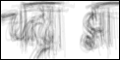
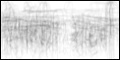
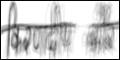
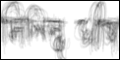
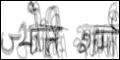
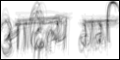
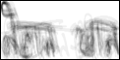
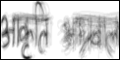
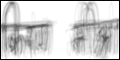
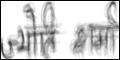
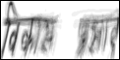


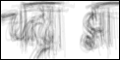
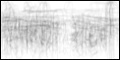
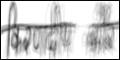
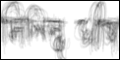
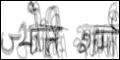
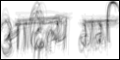
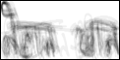
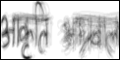
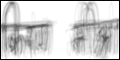
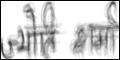
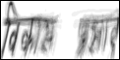

interactive(children=(IntSlider(value=0, description='num', max=10), Output()), _dom_classes=('widget-interact…

,Cluster label,#Points clustered,Chandra Jha,Aakrthi Agarwal,Aditya Garg,Dipanvita Sahani,Vikas Prasad,Milind Gheesh,Kirandeep Kaur,Jyoti Sharma,Kiran Mishra,Nehal Khan
0,Chandra Jha,17,100.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%
1,Dipanvita Sahani,31,6.45%,6.45%,6.45%,58.06%,3.23%,6.45%,0.0%,6.45%,0.0%,6.45%
2,Kirandeep Kaur,19,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,100.0%,0.0%,0.0%,0.0%
3,Milind Gheesh,17,0.0%,0.0%,0.0%,0.0%,0.0%,100.0%,0.0%,0.0%,0.0%,0.0%
4,Jyoti Sharma,5,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,80.0%,0.0%,20.0%
5,Aditya Garg,17,0.0%,0.0%,100.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%
6,Nehal Khan,17,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,5.88%,94.12%
7,Aakrthi Agarwal,17,0.0%,100.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%
8,Kiran Mishra,19,0.0%,0.0%,0.0%,5.26%,0.0%,0.0%,0.0%,0.0%,94.74%,0.0%
9,Jyoti Sharma,13,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,100.0%,0.0%,0.0%


In [306]:
#find centroids and clusters
centroids, clusters = kMeansWithLabel(genuines, 11, manhattan, 200)
#display images
ipyplot.plot_images(showCentroids(centroids), img_width = 120, max_images = 200, labels = [elt.label for elt in centroids])
interact(displayClusters, num = widgets.IntSlider(min = 0, max = len(clusters) - 1, step=1, value = 0))
#info table
centroidInfo(centroids, clusters, list(set(lbls)))

### Finding optimal k-values

In [112]:
#calculates the sum of squares within a cluster
def getSSW(centroids, clusters, dist):
    SSW = 0
    for centroid, cluster in zip(centroids, clusters):
        SSW += sum(dist(centroid.point, elt.point)**2 for elt in cluster)
        
    return SSW

#finds SSW for range of k values
def findSSW(k_max, dist):
    SSW = []
    for k in range(2, k_max):
        centroids, clusters = kMeansWithLabel(genuines, k, dist, 200, False)
        SSW.append(getSSW(centroids, clusters, dist))
    
    return SSW

#plots SSW vs. k
def findOptimalElbow(num_iter, k_max, dist):
    SSWlist = [findSSW(k_max, dist) for i in range(num_iter)]
    avg = np.mean(SSWlist, axis = 0)
    err = np.std(SSWlist, axis = 0)
    
    c = "C4"
    plt.plot(range(2, k_max), avg, color = c, zorder = 10, label = "Avg. curve")
    plt.plot(range(2, k_max), avg - err, color = c, ls = "dashed", alpha = 0.7, zorder = 10)
    plt.plot(range(2, k_max), avg + err, color = c, ls = "dashed", alpha = 0.7, zorder = 10)

    plt.fill_between(range(2, k_max), avg - err, avg + err, color = c, alpha = 0.5, zorder = 10, label = "Error")
    plt.xlabel("# of clusters (k)")
    plt.ylabel("Sum of Squares within Clusters (SSW)")
    plt.title("K-means clustering: Elbow Curve")
    plt.legend()
    return plt.show()

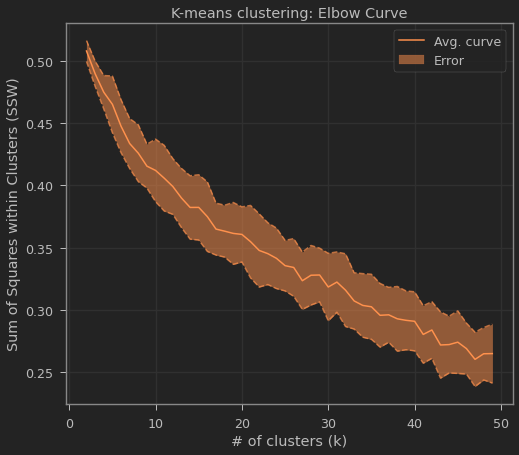

In [203]:
findOptimalElbow(30, 50, manhattan)

### Inspecting the distance distribution of each cluster

In [139]:
def getDistances(centroids, clusters, dist):
    dists = [[dist(elt.point, centroids[k].point) for elt in clusters[k]] for k in range(len(clusters))]
    return dists

In [140]:
distlist = getDistances(centroids, clusters, manhattan)

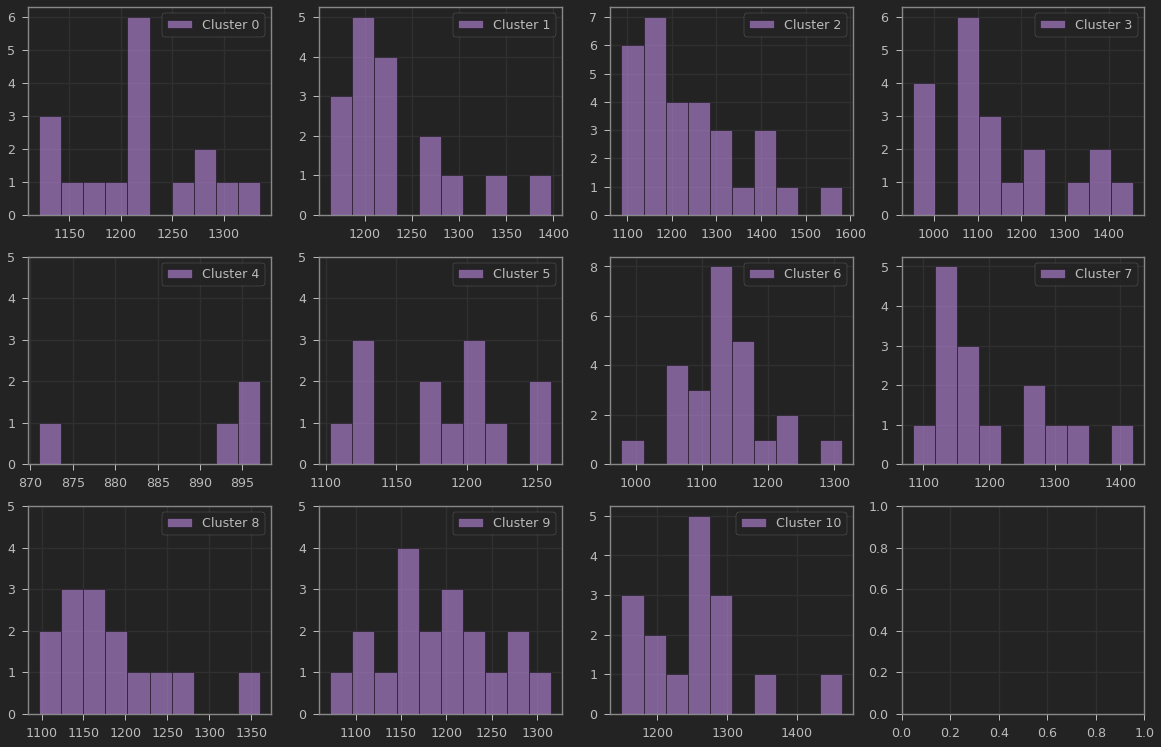

In [257]:
r, c = 3, 4
fig, axes = plt.subplots(r, c, figsize = (20, 13))
try:
    for i in range(r):
        for j in range(c):
            ind = c * i + j
            axes[i][j].hist(distlist[ind], zorder = 10, color = "C10", alpha = 0.6, edgecolor= 'black', linewidth = 0.65, label = "Cluster " + str(ind))
            axes[i][j].legend()
            axes[i][j].set_ylim(0, max(5, axes[i][j].get_ylim()[1]))

    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    plt.suptitle("Distribution of cluster distances from each centroid")
except Exception:
    pass

### Fraud detection

In [289]:
#calculate tolerance for each centroid as mean + 0.5 * stdev
def getTols(centroids, clusters, dist):
    mean_tols = np.array([np.mean([dist(elt.point, centroids[k].point) for elt in clusters[k]]) for k in range(len(clusters))])
    err_tols = np.array([np.std([dist(elt.point, centroids[k].point) for elt in clusters[k]]) for k in range(len(clusters))])
    return mean_tols + 0.5 * err_tols

def processPoint(vec, centroids, tolerance, dist):
    dists = np.array([dist(vec, centroid.point) for centroid, tol in zip(centroids, tolerance)])
    comp = np.less_equal(dists, tolerance)
    
    return dists, comp

#classifies new sample as genuine or forgery and displays tables
def classify(im, centroids, dist, disp = True):
    
    dists, comp = processPoint(im, centroids, tolerance, dist)
    data = []
    for i in range(len(dists)):
        data.append([round(dists[i], 2), round(tolerance[i], 2), comp[i]])

    #find nearest cluster centroid
    closest = centroids[np.argmin(dists)]
    
    if(disp):
        table = pd.DataFrame(data, columns = ["Distances", "Tolerances", "Acceptance"])
        display(table)
    
        if(comp.any()):
            print("Genuine signature, belonging to cluster - " + closest.label + f" ({np.argmin(dists)})")
        else:
            print("Forgery signature, closest to cluster - " + closest.label + f" ({np.argmin(dists)})")

        return vecToImage(closest.point).show(), vecToImage(im).show()
    else:
        return comp.any()

In [266]:
#to quantify accuracy of predictions

def confusionMatrix(forg, gen):
    
    forged_res = np.array([classify(imageToVec(img), centroids, manhattan, False) for img in forg])
    FP = np.count_nonzero(forged_res)/len(forged_res) * 100
    
    genuine_res = np.array([classify(imageToVec(img), centroids, manhattan, False) for img in gen])
    TP = np.count_nonzero(genuine_res)/len(genuine_res) * 100
    
    data = [[str(round(TP, 2)) + "%", str(round(FP, 2)) + "%"], [str(round(100 - TP, 2)) + "%", str(round(100 - FP, 2)) + "%"]]
    table = pd.DataFrame(data, ["Predicted Genuine", "Predicted Forgery"], ["Actual Genuine", "Actual Forgery"])
    display(table)

In [250]:
#loading test data for classification
lbls, forged_test = getImages("F", [elt for elt in range(1, 11) if elt not in ignore], range(1, 30))
lbls, genuines_test = getImages("G", [elt for elt in range(1, 11) if elt not in ignore], range(20, 25))

In [292]:
centroids, clusters = kMeansWithLabel(genuines, 11, manhattan, 200)
tolerance = getTols(centroids, clusters, manhattan)
confusionMatrix(forged_test, genuines_test)

Converged in 11 iterations.


,Actual Genuine,Actual Forgery
Predicted Genuine,80.0%,66.55%
Predicted Forgery,20.0%,33.45%


,Distances,Tolerances,Acceptance
0,1635.18,0.00,False
1,1427.88,1192.27,False
2,1405.37,1327.11,False
3,1264.13,1242.09,False
4,1599.60,1297.88,False
5,1625.12,1258.06,False
6,1708.24,617.24,False
7,1569.32,1242.62,False
8,1645.02,1283.37,False
9,1670.75,1076.64,False


Forgery signature, closest to cluster - Chandra Jha (3)


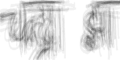

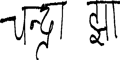

(None, None)

In [256]:
im = imageToVec(forged[78])
classify(im, centroids, manhattan)